In [1]:
import os
import shutil
import glob
import random
import warnings
import subprocess
import concurrent.futures
import multiprocessing
from itertools import chain
from collections import defaultdict, OrderedDict
from functools import partial
from scipy import stats, sparse
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import anndata
import networkx as nx
import scanpy as sc
import seaborn as sns
import h5py
import scglue
import multiprocessing
import matplotlib.pyplot as plt
from lisa.core.data_interface import DataInterface
from lisa import FromCoverage, FromGenes, FromRegions
from lisa.core.assays import LISA_RP_Assay, delta_RP_wrapper, transform_RP,get_delta_RP,get_deltaRP_activation
from supercell import *
from Ori_data import *
from utils import *
warnings.filterwarnings("ignore")

/fs/home/xuyunfan/miniconda3/envs/scrip/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import scripro

In [193]:
import scglue
import anndata
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")

In [3]:
miradata = anndata.read_h5ad('/fs/home/xuyunfan/project/scripmulti/mira/trajectory.h5ad')

In [270]:
scrip = pd.read_csv('/fs/home/xuyunfan/data/mira/gse/atac/Mouse/enrichment/SCRIP_enrichment.txt',sep='\t',index_col=0)

In [5]:
atac = sc.read_h5ad('/fs/home/xuyunfan/project/scripmulti/mira/atac_scrip.h5ad')

In [6]:
rna = sc.read_h5ad("/fs/home/xuyunfan/data/mira/shareseq_base_data/rna_data.h5ad")

In [7]:
select_cell = list(set(miradata.to_df().index).intersection(scrip.index).intersection(atac.to_df().index).intersection(rna.to_df().index))

In [8]:
miradata = miradata[select_cell]

In [9]:
atac =  atac[select_cell]

In [10]:
atac_df=atac.to_df()

In [11]:
scripro.process_and_merge(atac_df, './', n_num=8)

In [12]:
rna =rna[select_cell]

In [13]:
rna.var_names_make_unique()
rna.var_names = [x.capitalize() for x in rna.var_names]

In [14]:
test_data = scripro.Ori_Data(rna,Cell_num=50)

In [15]:
%%time
test_data.get_positive_marker_gene_parallel(cores=4)

CPU times: user 2.33 s, sys: 1.87 s, total: 4.2 s
Wall time: 4.28 s


In [16]:
cellgroup = test_data.adata.obs.loc[:,['new_leiden']]

In [18]:
scripro.get_supercell_fragment(cellgroup,'.','./merge.tsv',chunksize = 10000000)

Processed chunk 1
Processed chunk 2
Processed chunk 3
final


In [19]:
scripro.process_tsv('./supercell_fragment/', '/fs/home/xuyunfan/data/bedGraphToBigWig','/fs/home/xuyunfan/data/mm10.genome')

In [20]:
share_seq_data = scripro.SCRIPro_Multiome(8,'mm10',test_data)

In [25]:
%%time
share_seq_data.cal_ISD_parallel('./bigwig/')

Loading gene info ...
Converting BigWig file to coverage array ...
Progress: [>                        ]Converting BigWig file to coverage array ...
Progress: [>                        ]Converting BigWig file to coverage array ...
Progress: [>                        ]Converting BigWig file to coverage array ...
Progress: [>                        ]Converting BigWig file to coverage array ...
Progress: [>                        ]Converting BigWig file to coverage array ...
Progress: [>                        ]Converting BigWig file to coverage array ...
Progress: [>                        ]Converting BigWig file to coverage array ...
Progress: [=========================]
Progress: [=========================]
Progress: [=========================]
Progress: [=========================]
Progress: [=========================]
Progress: [=========================]
Progress: [=========================]
Progress: [=========================]
Converting BigWig file to coverage array ...
Progress: 

CPU times: user 1min 25s, sys: 36.2 s, total: 2min 2s
Wall time: 25min 58s


In [27]:
share_seq_data.get_P_value_matrix()

In [28]:
share_seq_data.get_chip_matrix()

In [30]:
target_h5=pd.HDFStore('/fs/home/xuyunfan/data/ALL_target_3.h5')

In [33]:
%%time
share_seq_data.get_tf(target_h5)

CPU times: user 1min 20s, sys: 354 ms, total: 1min 21s
Wall time: 1min 21s


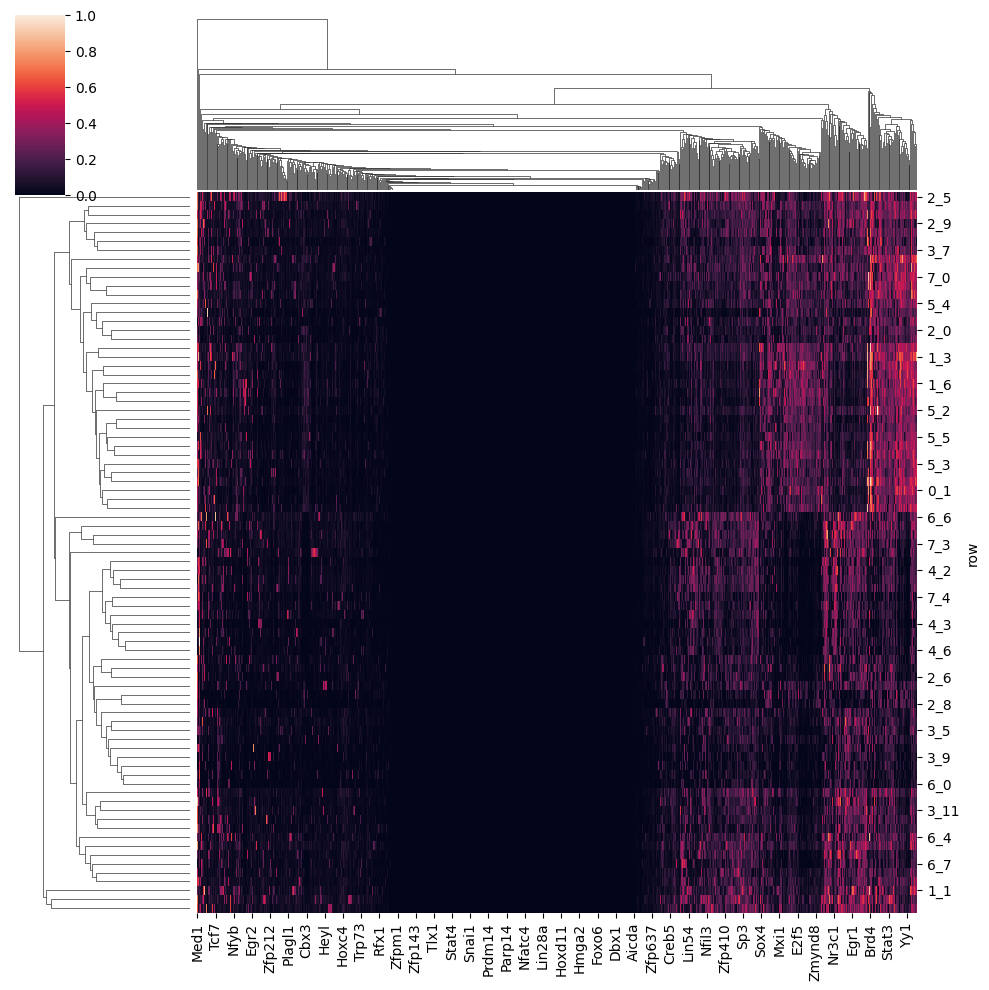

In [37]:
sns.clustermap(share_seq_data.tf_score)

In [120]:
all_pro_score = pd.merge(test_data.adata.obs,share_seq_data.tf_score,left_on='new_leiden',right_index=True)

In [70]:
select_cell2 = list(set(select_cell).intersection(all_pro_score.index))

In [272]:
scrip = (scrip - scrip.min())/(scrip.max()-scrip.min())

In [273]:
scrip = scrip.loc[select_cell2,:]

In [298]:
trajectory_data = sc.read_h5ad('/fs/home/xuyunfan/project/SCRIPro/package/trajectory.h5ad')

In [299]:
trajectory_data = trajectory_data[select_cell2]

In [300]:
tra = trajectory_data.obs

In [301]:
Medulla_tra = tra[tra['Medulla_prob'] >0.25].sort_values(by = 'Medulla_prob').index

In [302]:
Medulla_score =all_pro_score.loc[Medulla_tra,:]

In [303]:
Medulla_score.index = Medulla_score['true_cell']

In [304]:
Medulla_score =Medulla_score.iloc[:,5:]

In [305]:
Medulla_score = (Medulla_score - Medulla_score.min())/(Medulla_score.max() - Medulla_score.min())

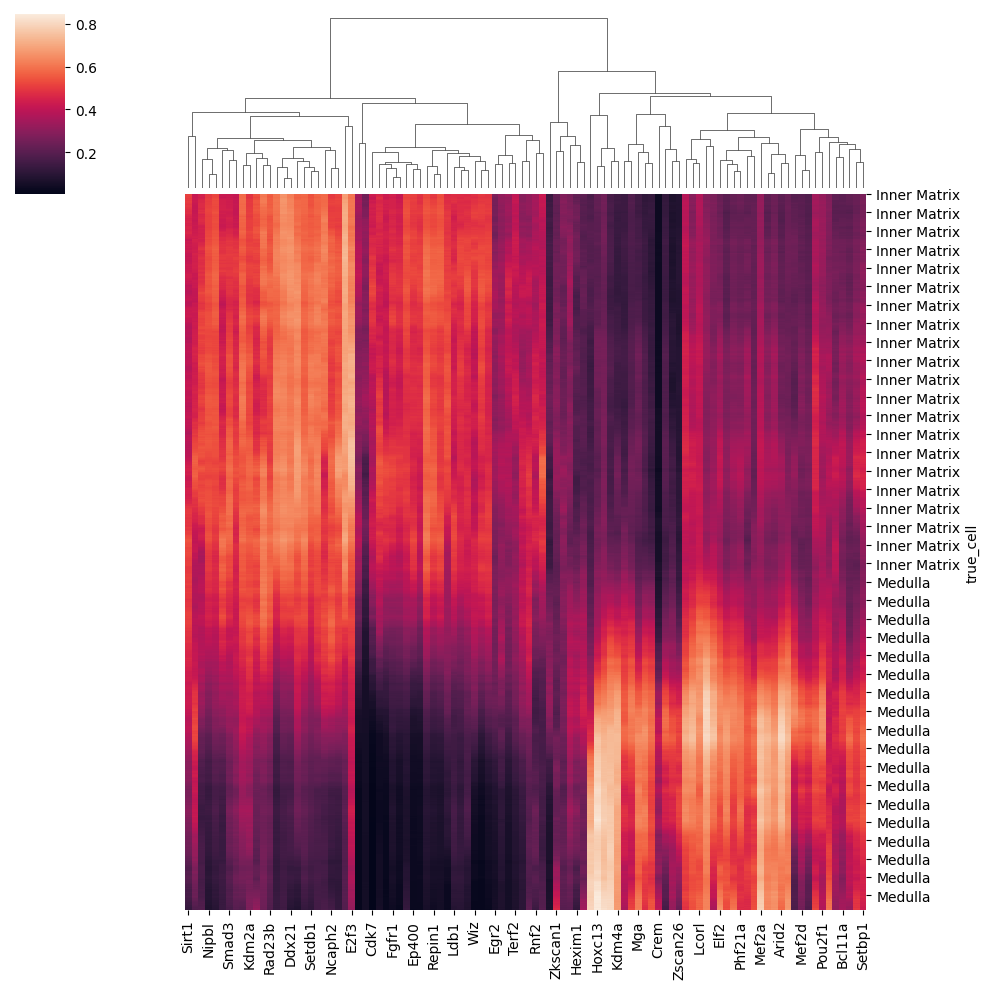

In [311]:
sns.clustermap(Medulla_score.loc[:,Medulla_score.std().sort_values(ascending = False)[0:100].index].rolling(window=100).mean().iloc[100:,:],row_cluster=False)

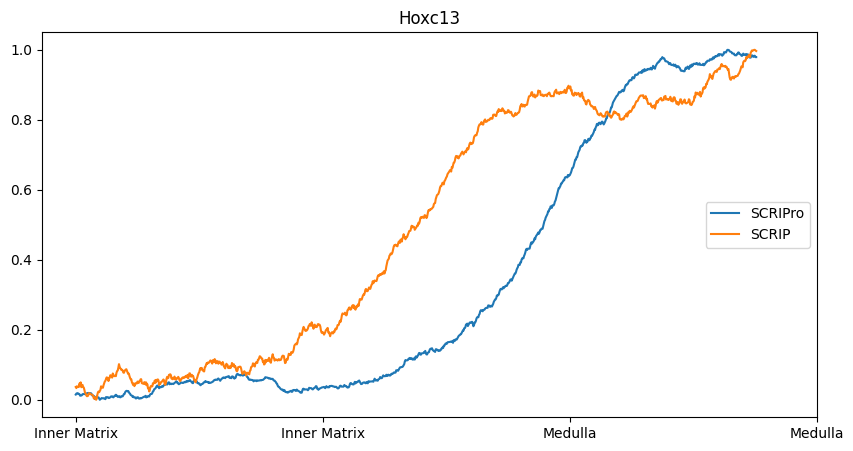

In [212]:
plt.figure(figsize=(10, 5))
TF = 'Hoxc13'
data_series1=pd.Series(list(Medulla_score.loc[:,TF]))
smooth_data1 = data_series1.rolling(window=200).mean()
smooth_data1 = (smooth_data1 - smooth_data1.min())/(smooth_data1.max() - smooth_data1.min())
plt.plot(smooth_data1[200:].reset_index(drop = True), label='SCRIPro')

data_series2=pd.Series(list(scrip.loc[Medulla_tra,TF]))
smooth_data2 = data_series2.rolling(window=200).mean()
smooth_data2 = (smooth_data2 - smooth_data2.min())/(smooth_data2.max() - smooth_data2.min())
plt.plot(smooth_data2[200:].reset_index(drop = True), label='SCRIP')

# set xticks every 200 steps
xticks_locs = np.arange(0, len(Medulla_score.index), 400)
plt.xticks(xticks_locs, Medulla_score.index[xticks_locs])
plt.title(TF)
plt.legend(loc='right')


plt.show()